### Can we classify each phase as relatively low or high anxiety for each subject? ###
#### APD, POPANE ####

In [1]:
# IMPORTING MODULES
import glob
import importlib
import matplotlib.pyplot as plt
import numpy as np
import os
cvx_path = os.path.abspath(os.path.join('..', '..', 'cvxEDA', 'src'))
module_path = os.path.abspath(os.path.join('..', '..', 'src'))
import pandas as pd
import random
import scipy.signal as ss
import shap
import sys
sys.path.append(module_path)

import tools.data_reader_apd as dr_a
import tools.data_reader_popane as dr_p
import tools.display_tools as dt
import tools.preprocessing as preprocessing
import train

from scipy.fft import fft, fftfreq, fftshift
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.preprocessing import normalize
from xgboost import XGBClassifier

import cvxopt.solvers
cvxopt.solvers.options['show_progress'] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    category=RuntimeWarning
)
warnings.simplefilter(action='ignore', category=FutureWarning)

c:\Users\zhoux\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
metrics = [
    train.Metrics.BPM, 
    train.Metrics.RMSSD, 
    train.Metrics.HF_RR, 
    train.Metrics.LF_RR, 
    train.Metrics.IBI, 
    train.Metrics.SDNN, 
    train.Metrics.MEAN_SCL, 
    train.Metrics.SCR_RATE
]

model_phases_apd = [
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", "BugBox_Exposure", "BugBox_Break",
        "Speech_Relax", "Speech_Anticipate", "Speech_Exposure", "Speech_Break"
    ],
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", "BugBox_Break",
        "Speech_Relax", "Speech_Anticipate", "Speech_Break"
    ],
    [
        "Baseline_Rest", 
        "BugBox_Relax", "BugBox_Anticipate", 
        "Speech_Relax", "Speech_Anticipate"
    ],
    # [
    #     "Baseline_Rest", 
    #     "BugBox_Relax", "BugBox_Anticipate", "BugBox_Break",
    #     "Speech_Relax", "Speech_Anticipate", "Speech_Break"
    # ],
    ["BugBox_Break", "Speech_Break"],
    ["BugBox_Exposure", "Speech_Exposure"]
]

studies_popane = [
    "Study1",
    # "Study2",
    "Study3",
    "Study4",
    "Study5",
    # "Study6",
    # "Study7"
]

model_phases_popane = [
    dr_p.Study1.ALL,
    # dr_p.Study2.ALL,
    dr_p.Study3.ALL,
    dr_p.Study4.ALL,
    dr_p.Study5.ALL
    # dr_p.Study6.ALL
    # dr_p.Study7.ALL
]

apd_label_type = "Anxiety"
popane_label_type = "affect"

models = {
    "SVM": SVC(C=10, gamma=1),  # C=10, gamma=1
    # "KNN": KNeighborsClassifier(n_neighbors=7),
    # "DT": DecisionTreeClassifier(),
    "LogReg": LogisticRegression(max_iter=1000),
    # "Bayes": GaussianNB(),
    "XGB": XGBClassifier(use_label_encoder=False, objective="binary:logistic", eval_metric="logloss")
}

test_size = 0.8

`use_label_encoder` is deprecated in 1.7.0.


POPANE PHASES 0 --------------------------------------------------
APD PHASES 0 --------------------------------------------------
SVM accuracy over 10 rounds: 0.579664328375028
LogReg accuracy over 10 rounds: 0.6298449121027723
XGB accuracy over 10 rounds: 0.5609526839809622


POPANE PHASES 1 --------------------------------------------------
APD PHASES 0 --------------------------------------------------
SVM accuracy over 10 rounds: 0.5705012762729547
LogReg accuracy over 10 rounds: 0.5504589295557991
XGB accuracy over 10 rounds: 0.52747078402089


POPANE PHASES 2 --------------------------------------------------
APD PHASES 0 --------------------------------------------------
Only one class present in y_true. ROC AUC score is not defined in that case. Setting AUC score to -1.
Only one class present in y_true. ROC AUC score is not defined in that case. Setting AUC score to -1.
Only one class present in y_true. ROC AUC score is not defined in that case. Setting AUC score to -1.
Only o

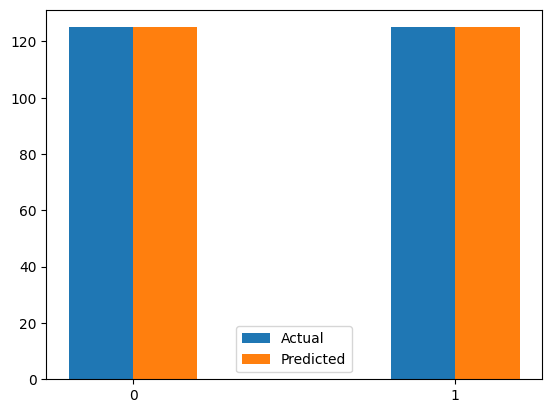

LogReg accuracy over 10 rounds: 1.0
Model evaluation metrics for LogReg:
Precision: 1.0
Recall: 1.0
F1-score: 1.0
AUC score: -1.0


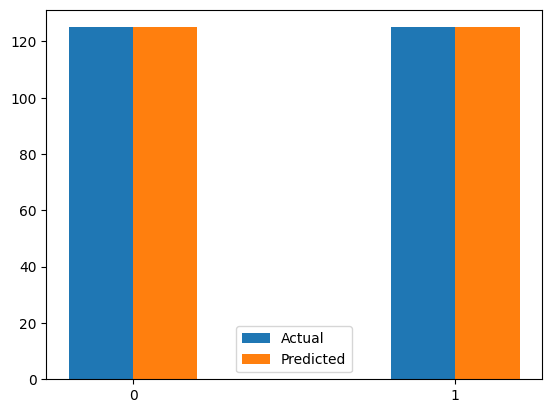

XGB accuracy over 10 rounds: 0.9944063492063492
Model evaluation metrics for XGB:
Precision: 1.0
Recall: 0.9944063492063492
F1-score: 0.997185477548286
AUC score: -1.0


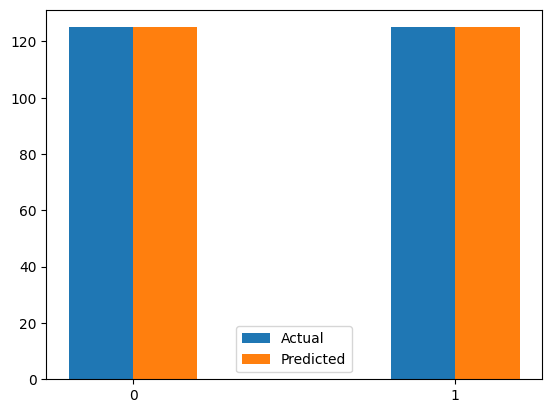



POPANE PHASES 3 --------------------------------------------------
APD PHASES 0 --------------------------------------------------


IndexError: single positional indexer is out-of-bounds

In [18]:
# TRAIN ON APD AND TEST ON POPANE
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dt)


for i, phases_apd in enumerate(model_phases_apd):
    for j, study in enumerate(studies_popane):
        print(f"POPANE PHASES {j} " + "-"*50)
        print(f"APD PHASES {i} " + "-"*50)
        x_a, y_a = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=apd_label_type, threshold=threshold)
        x_b, y_b = train.Train_POPANE.get_popane_data(study, metrics, model_phases_popane[j], verbose=False, label_type=popane_label_type, threshold=threshold)
        inds = pd.isnull(x_b).any(1).to_numpy().nonzero()[0]
        x_b = x_b.drop(inds, axis=0)
        y_b = y_b.drop(inds, axis=0)

        x_a = x_a.drop(["phaseId"], axis=1)
        x_b = x_b.drop(["phaseId"], axis=1)

        # drop subjects with noisy data
        x_a = x_a[x_a['subject'] != 84.0]
        x_a = x_a.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because POPANE doesn't have this feature
        y_a = y_a[y_a['subject'] != 84.0]
        # x = x[x['subject'] != 8.0]
        # y = y[y['subject'] != 8.0]

        # make sure subjects from different datasets aren't labeled with the same index
        x_b["subject"] = x_b["subject"] + 500

        # 0-1 scaling
        for c in range(3, len(x_a.columns)):
            data_col = x_a[x_a.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_a[x_a.columns[c]] = data_col
        # 0-1 scaling
        for c in range(3, len(x_b.columns)):
            data_col = x_b[x_b.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_b[x_b.columns[c]] = data_col

        # print(y_a.loc[:, "label"].value_counts() + y_b.loc[:, "label"].value_counts())

        acc_results = {
            "SVM": [], 
            # "KNN": [],
            # "DT": [],
            "LogReg": [],
            # "Bayes": [],
            "XGB": []
        }
        reports = {
            "SVM": [], 
            # "KNN": [],
            # "DT": [],
            "LogReg": [],
            # "Bayes": [],
            "XGB": [],
        }
        num_iters = 10
        for _ in range(num_iters):
            out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=False, save_metrics=True, test_size=test_size)
            for model_name in acc_results:
                acc_results[model_name].append(out[model_name][0])
                reports[model_name].append(out[model_name][1])

        for model_name in acc_results.keys():
            acc = np.mean(acc_results[model_name])
            print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
            if acc > 0.65:
                print(f"Model evaluation metrics for {model_name}:")
                p = np.mean([report["precision"] for report in reports[model_name]])
                r = np.mean([report["recall"] for report in reports[model_name]])
                f1 = np.mean([report["f1"] for report in reports[model_name]])
                idx = np.argmax([report["f1"] for report in reports[model_name]])
                auc = np.mean([report["auc"] for report in reports[model_name]])
                report = reports[model_name]
                print(f"Precision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
                plot_y = reports[model_name][idx]["actual vs pred"]
                _, y_test_counts = np.unique(plot_y[0], return_counts=True)
                _, y_pred_counts = np.unique(plot_y[1], return_counts=True)
                br1 = [0, 0.5]
                br2 = [1, 1.5]
                
                x = [0, 1]
                x_axis = np.arange(len(x))
                plt.bar(x_axis-0.1, y_test_counts, 0.2, label="Actual")
                plt.bar(x_axis+0.1, y_pred_counts, 0.2, label="Predicted")
                plt.xticks(x_axis, x)
                plt.legend()
                plt.show()

        print("\n")

In [10]:
# TRAIN ON POPANE AND TEST ON APD
importlib.reload(train)
importlib.reload(dr_a)
importlib.reload(dr_p)
importlib.reload(dt)


for i, study in enumerate(studies_popane):
    for j, phases_apd in enumerate(model_phases_apd):
        print(f"POPANE PHASES {j} " + "-"*50)
        print(f"APD PHASES {i} " + "-"*50)
        x_a, y_a = train.Train_POPANE.get_popane_data(study, metrics, model_phases_popane[i], verbose=False, label_type=popane_label_type, threshold=threshold)
        x_b, y_b = train.Train_APD.get_apd_data_ranking(metrics, phases_apd, verbose=False, anxiety_label_type=apd_label_type, threshold=threshold)
        inds = pd.isnull(x_a).any(1).to_numpy().nonzero()[0]
        x_a = x_a.drop(inds, axis=0)
        y_a = y_a.drop(inds, axis=0)

        x_a = x_a.drop(["phaseId"], axis=1)
        x_b = x_b.drop(["phaseId"], axis=1)

        # drop subjects with noisy data
        x_b = x_b[x_b['subject'] != 84.0]
        x_b = x_b.drop(["anxietyGroup"], axis=1)  # drop anxietyGroup column because POPANE doesn't have this feature
        y_b = y_b[y_b['subject'] != 84.0]
        # x = x[x['subject'] != 8.0]
        # y = y[y['subject'] != 8.0]

        # make sure subjects from different datasets aren't labeled with the same index
        x_b["subject"] = x_b["subject"] + 500

        # 0-1 scaling
        for c in range(3, len(x_a.columns)):
            data_col = x_a[x_a.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_a[x_a.columns[c]] = data_col
        # 0-1 scaling
        for c in range(3, len(x_b.columns)):
            data_col = x_b[x_b.columns[c]]
            data_col = (data_col - data_col.min())/(data_col.max() - data_col.min())
            x_b[x_b.columns[c]] = data_col

        print(y_a.loc[:, "label"].value_counts() + y_b.loc[:, "label"].value_counts())
        
        acc_results = {
            "SVM": [], 
            # "KNN": [],
            # "DT": [],
            "LogReg": [],
            # "Bayes": [],
            "XGB": []
        }
        reports = {
            "SVM": [], 
            # "KNN": [],
            # "DT": [],
            "LogReg": [],
            # "Bayes": [],
            "XGB": [],
        }
        num_iters = 10
        for _ in range(num_iters):
            out = train.Train_Multi_Dataset.train_across_datasets(models, x_a, y_a, x_b, y_b, by_subject=False, save_metrics=True, test_size=test_size)
            for model_name in acc_results:
                acc_results[model_name].append(out[model_name][0])
                reports[model_name].append(out[model_name][1])

        for model_name in acc_results.keys():
            acc = np.mean(acc_results[model_name])
            print(f"{model_name} accuracy over {num_iters} rounds: {acc}")
            if acc > 0.65:
                print(f"Model evaluation metrics for {model_name}:")
                p = np.mean([report["precision"] for report in reports[model_name]])
                r = np.mean([report["recall"] for report in reports[model_name]])
                f1 = np.mean([report["f1"] for report in reports[model_name]])
                auc = np.mean([report["auc"] for report in reports[model_name]])
                report = reports[model_name]
                print(f"Precision: {p}\nRecall: {r}\nF1-score: {f1}\nAUC score: {auc}")
        print("\n")

POPANE PHASES 0 --------------------------------------------------
APD PHASES 0 --------------------------------------------------
1    535
0    291
Name: label, dtype: int64
SVM accuracy over 10 rounds: 0.6814189481981782
Model evaluation metrics for SVM:
Precision: 0.6808829641662089
Recall: 0.9975504943394293
F1-score: 0.8092945329284704
AUC score: 0.5069889059844966
LogReg accuracy over 10 rounds: 0.6627286421852971
Model evaluation metrics for LogReg:
Precision: 0.6919509711472477
Recall: 0.9166361561367831
F1-score: 0.7844828373811394
AUC score: 0.5260228709461694
XGB accuracy over 10 rounds: 0.6407670459706563


POPANE PHASES 1 --------------------------------------------------
APD PHASES 0 --------------------------------------------------
1    463
0    261
Name: label, dtype: int64
SVM accuracy over 10 rounds: 0.64592700167891
LogReg accuracy over 10 rounds: 0.642699878210163
XGB accuracy over 10 rounds: 0.6051250560304171


POPANE PHASES 2 ------------------------------------